The purpose of this notebook is to investigate an alternative method for counting instances of moderate/vigorous physical activity [MVPA]

We'll start by segmenting each day into 5-minute "bouts"

But rather than compute the percent of bouts that are MVPA, we'll do the following:
1. Identify each day as having had the accelerometer on enough to believe that it was on for most/all waking hours
2. Counting the number of such days
3. Counting the number of MVPA bouts on these days and identifying them as "active" days
4. Computing the average MVPA bouts per active day

In [11]:
# Start by importing packages we'll need
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [21]:
# Load the parquet data file series_train.parquet/id=0a418b57/part-0.parquet
data0a418b57 = pd.read_parquet('series_train.parquet/id=0a418b57/part-0.parquet')
data0a431608 = pd.read_parquet('series_train.parquet/id=0a431608/part-0.parquet')
data0b7d7aec = pd.read_parquet('series_train.parquet/id=0b7d7aec/part-0.parquet')
data0b7d9da6 = pd.read_parquet('series_train.parquet/id=0b7d9da6/part-0.parquet')
data0b50f3fa = pd.read_parquet('series_train.parquet/id=0b50f3fa/part-0.parquet')

# Create a list of the five data sets imported above
dataset_list = [data0a418b57, data0a431608, data0b7d7aec, data0b7d9da6, data0b50f3fa]

# Add a new column that converts time_of_day into datetime
#data0a418b57['dt'] = pd.to_datetime(data0a418b57['time_of_day'])
for df in dataset_list:
    df['dt'] = pd.to_datetime(df['time_of_day'])

# Change the day in the dt variable to be equal to the relative_date_PCIAT value
#data0a418b57['dt_mod'] = data0a418b57['dt'] + pd.to_timedelta(data0a418b57['relative_date_PCIAT'], unit='D')

for df in dataset_list:
    df['dt_mod'] = df['dt'] + pd.to_timedelta(df['relative_date_PCIAT'], unit='D')

# Use dt_mod as the index. This will help with the resampling
#data0a418b57.set_index('dt_mod', inplace=True)
for df in dataset_list:
    df.set_index('dt_mod', inplace=True)

**Examining the data. A couple of things to point out**
* There is a gap from 14:15:00 to 16:02:10.
* There aren't any data from 16:00:00 to 16:02:10


** This will be sort of significant later for two reasons**

* First, when we use the .resample method, pandas is going to fill in all of the missing timestamp/index values
* Second, when we compute the mean as part of .resample, it will perform the computation when one or more values in the interval is not NaN
* We should probably figure out whether we want this second "feature"....


In [4]:
data0a418b57.head(30)

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,dt
dt_mod,,,,,,,,,,,,,,
1969-12-23 14:14:10,0,-0.075242,-0.256743,-0.973791,0.038081,-72.952141,0.0,5.000000,4202.000000,51250000000000,2,4,-9.0,1970-01-01 14:14:10
1969-12-23 14:14:15,1,-0.265893,-0.270508,-0.765470,0.077430,-52.849220,0.0,0.500000,4185.333496,51255000000000,2,4,-9.0,1970-01-01 14:14:15
1969-12-23 14:14:20,2,0.334517,-0.548602,-0.588596,0.039162,-44.118084,0.0,11.500000,4185.500000,51260000000000,2,4,-9.0,1970-01-01 14:14:20
1969-12-23 14:14:25,3,0.000193,-0.021069,-0.999681,0.001450,-88.759613,0.0,0.000000,4185.666504,51265000000000,2,4,-9.0,1970-01-01 14:14:25
1969-12-23 14:14:30,4,-0.000685,-0.020681,-0.997677,0.000491,-88.756958,0.0,8.500000,4185.833496,51270000000000,2,4,-9.0,1970-01-01 14:14:30
1969-12-23 14:14:35,5,-0.001201,-0.020681,-0.996271,0.000352,-88.755676,0.0,17.000000,4186.000000,51275000000000,2,4,-9.0,1970-01-01 14:14:35
1969-12-23 14:14:40,6,-0.000337,-0.020785,-0.995230,0.000245,-88.755211,0.0,13.666667,4186.166504,51280000000000,2,4,-9.0,1970-01-01 14:14:40
1969-12-23 14:14:45,7,-0.002015,-0.247497,-0.880097,0.079348,-80.229324,0.0,21.666666,4186.333496,51285000000000,2,4,-9.0,1970-01-01 14:14:45
1969-12-23 14:14:50,8,0.023610,-0.030509,-0.996245,0.010151,-87.902908,0.0,22.500000,4186.500000,51290000000000,2,4,-9.0,1970-01-01 14:14:50


In [177]:
# Below is some code I wrote to try to fill in missing timestamp values (i.e., where no data were recorded)
# BUT it seems like the .resample command does this when the index is a date-time object

# I'm keeping the code around for now in case I'm mistaken, but I'll comment it out

# Create a new dataframe
#data0a418b57_filled = pd.DataFrame()

# Create a series that fills in all of the timestamps from the start to the end of the data frame
#data0a418b57_filled.index = pd.date_range(data0a418b57.index[0], periods=len(data0a418b57), freq='5s')

# Merge the original data with the new filled-in-timestamp data frame
#data0a418b57_filled = data0a418b57_filled.merge(data0a418b57, how='left', left_index=True, right_index=True)

# Create a new data frame by splitting data0a418b57_filled into 5-minute intervals and computing the mean of each variable within the interval
#data0a418b57_resampled_5min = data0a418b57_filled.resample('5min').mean()

In [22]:
# Create a new data frame by grouping the observations into 5-minute intervals and computing the mean of each interval

data0a418b57_resampled_5min = data0a418b57.resample('5min').mean()
data0a431608_resampled_5min = data0a431608.resample('5min').mean()
data0b7d7aec_resampled_5min = data0b7d7aec.resample('5min').mean()
data0b7d9da6_resampled_5min = data0b7d9da6.resample('5min').mean()
data0b50f3fa_resampled_5min = data0b50f3fa.resample('5min').mean()


**We can check on the above hypotheses**

Examining the interval starting at 16:15, we can see that it has a value recorded, even though in the original data there were only three valid data points in this interval

The reported enmo value in this interval appears to be approximately the mean of the three recorded enmo values

In [230]:
data0a418b57_resampled_5min.head(30)

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,dt
dt_mod,,,,,,,,,,,,,,
1969-12-23 14:10:00,4.5,0.004360,-0.145778,-0.918847,0.024701,-78.099045,0.0,10.135992,4187.600098,5.127250e+13,2.0,4.0,-9.0,1970-01-01 14:14:32.500
1969-12-23 14:15:00,10.0,0.030891,-0.019828,-0.995308,0.000162,-87.887527,0.0,1.053176,4186.833496,5.130000e+13,2.0,4.0,-9.0,1970-01-01 14:15:00.000
1969-12-23 14:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1969-12-23 14:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1969-12-23 14:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1969-12-23 14:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1969-12-23 14:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1969-12-23 14:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1969-12-23 14:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


Next, we should figure out where to make the cutoff for the minimum number of valid 5-minute bouts to indicate whether the accelerometer was used frequently enough to suggest the participant (basically) had it turned on for most of their waking hours.

We'll count the number of valid bouts on each day and look at the distribution of values and a time-series graph

In [23]:
# Group the data frame by day and count the number of non-NaN values of the 'enmo' variable
#boutcount = data0a418b57_resampled_5min.groupby(data0a418b57_resampled_5min.index.date).count()['enmo']

boutcount_data0a418b57 = data0a418b57_resampled_5min.groupby(data0a418b57_resampled_5min.index.date).count()['enmo']
boutcount_data0a431608 = data0a431608_resampled_5min.groupby(data0a431608_resampled_5min.index.date).count()['enmo']
boutcount_data0b7d7aec = data0b7d7aec_resampled_5min.groupby(data0b7d7aec_resampled_5min.index.date).count()['enmo']
boutcount_data0b7d9da6 = data0b7d9da6_resampled_5min.groupby(data0b7d9da6_resampled_5min.index.date).count()['enmo']
boutcount_data0b50f3fa = data0b50f3fa_resampled_5min.groupby(data0b50f3fa_resampled_5min.index.date).count()['enmo']

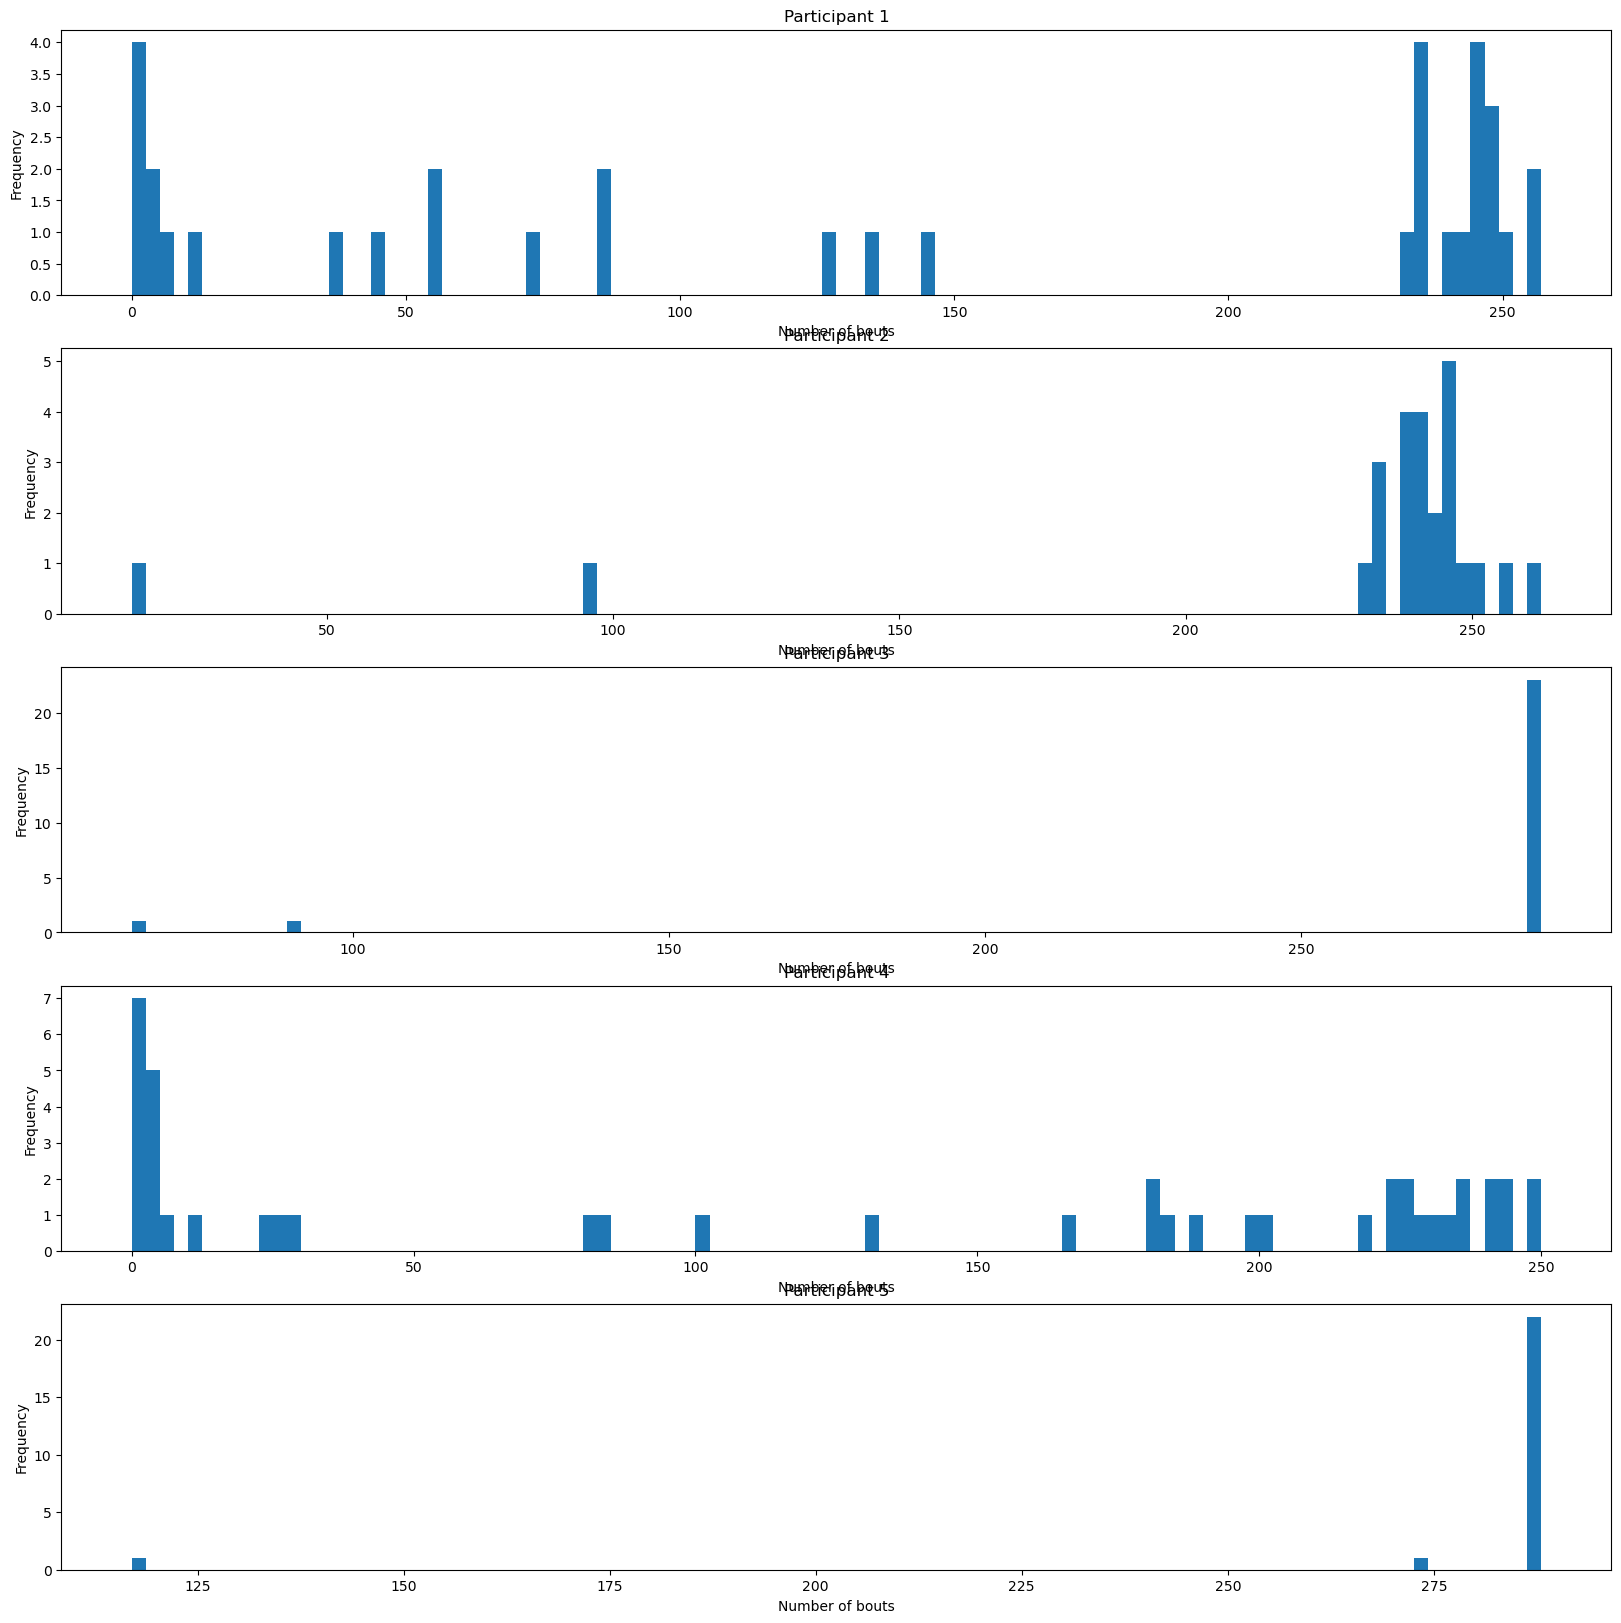

In [24]:
# Make a histogram of the values of boutcount

boutcountlist = [boutcount_data0a418b57,boutcount_data0a431608,boutcount_data0b7d7aec,boutcount_data0b7d9da6,boutcount_data0b50f3fa]

figure, axis = plt.subplots(5, 1, figsize=(20,20))

# For each column in boutcountlist, create a histogram and add it to the axis
for i in range(5):
    axis[i].hist(boutcountlist[i], bins=100)
    axis[i].set_title('Participant ' + str(i+1))
    axis[i].set_xlabel('Number of bouts')
    axis[i].set_ylabel('Frequency')

#fig = px.histogram(boutcount_data0a431608, x=boutcount_data0a431608, nbins=100)
#fig.show()

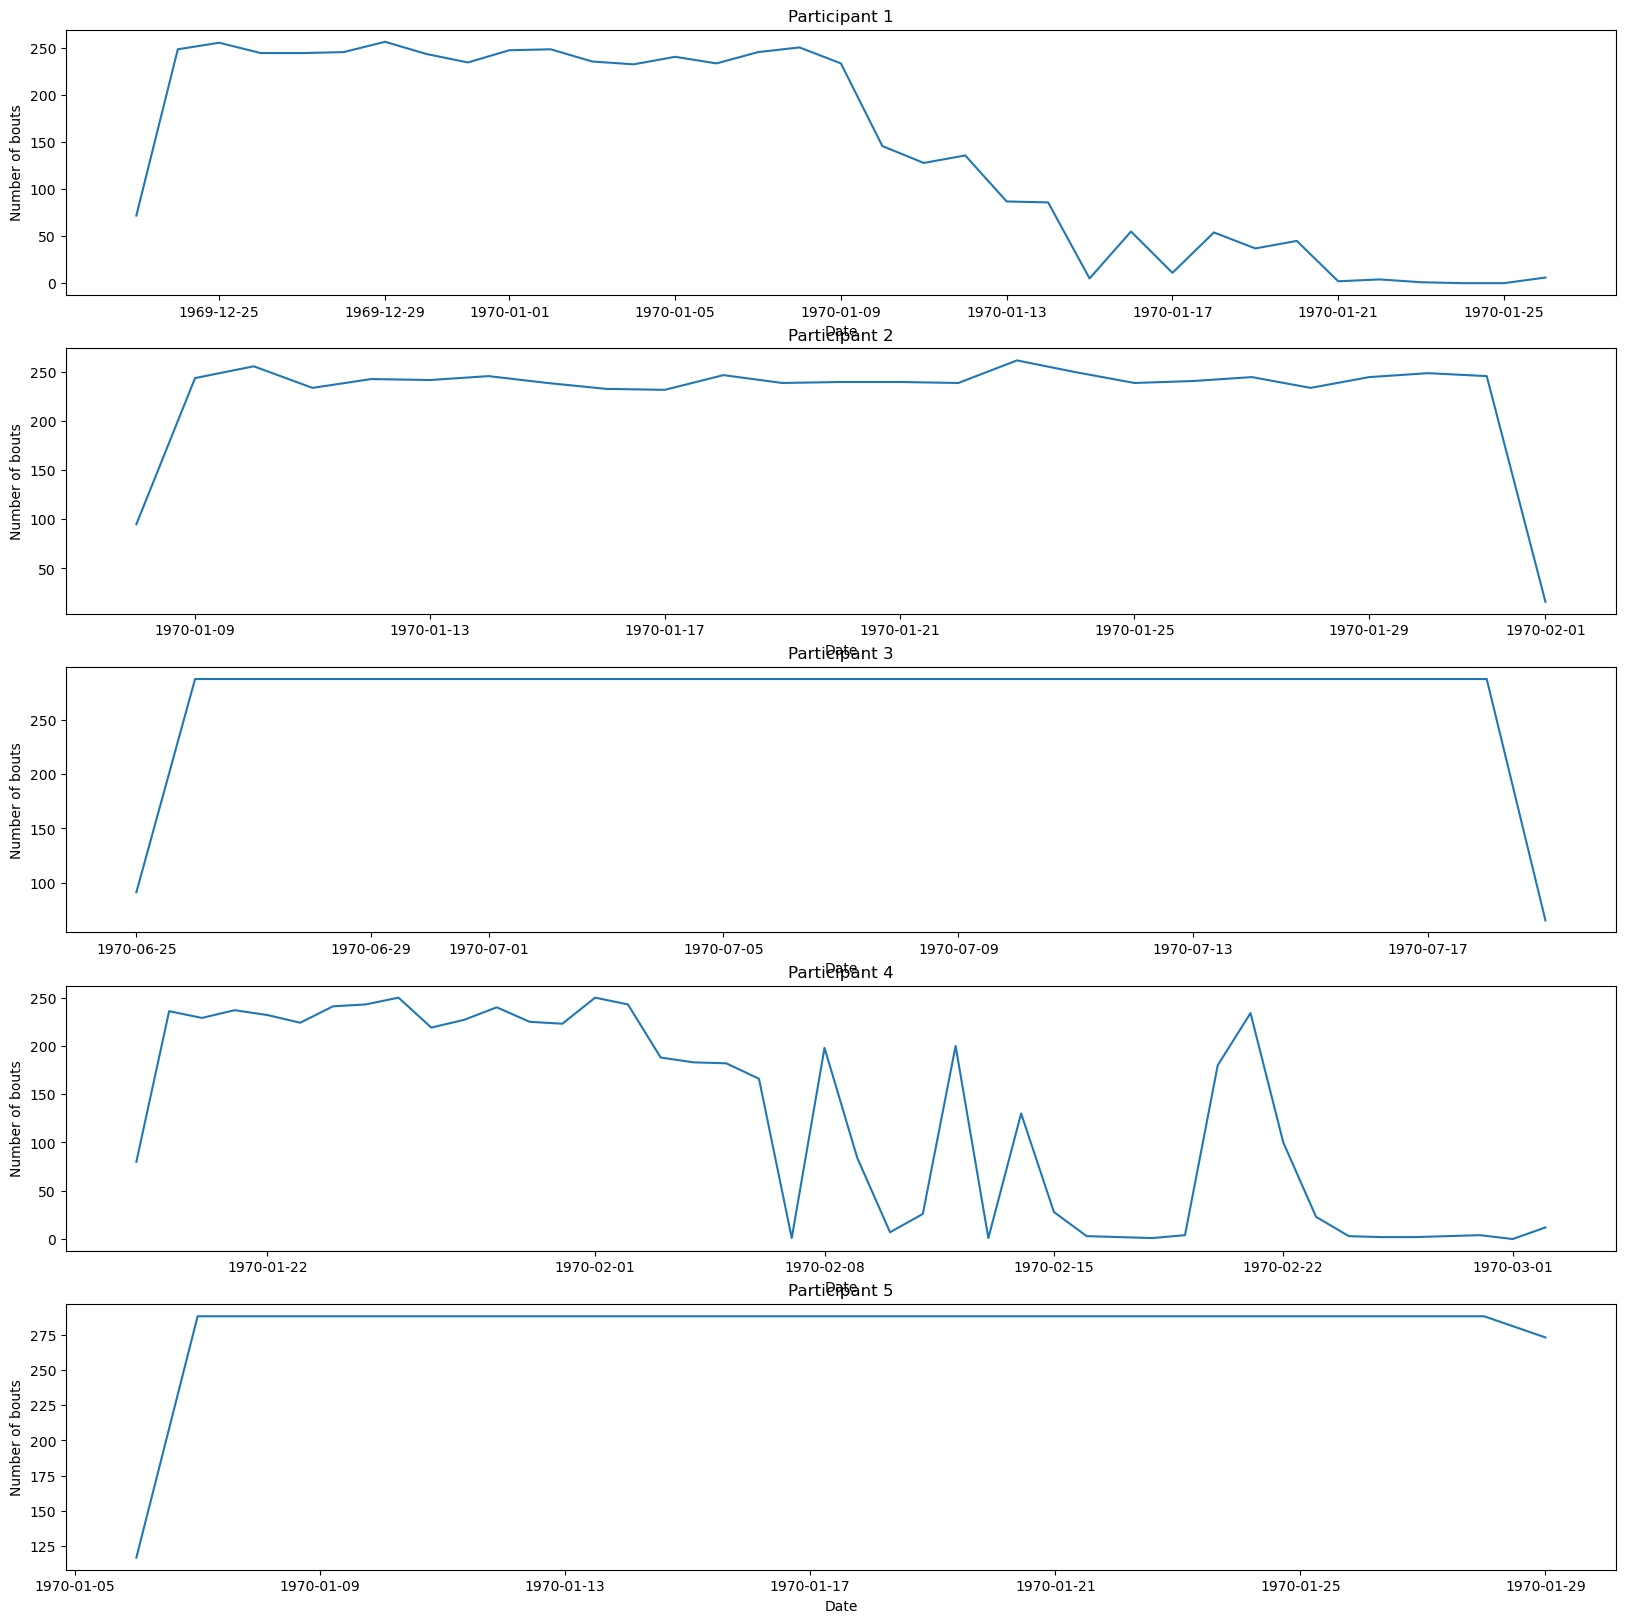

In [25]:
figure, axis = plt.subplots(5, 1, figsize=(20,20))

# For each column in boutcountlist, create a line plot and add it to the axis
for i in range(5):
    axis[i].plot(boutcountlist[i])
    axis[i].set_title('Participant ' + str(i+1))
    axis[i].set_xlabel('Date')
    axis[i].set_ylabel('Number of bouts')

# Make a graph of boutcount
#fig = go.Figure()
#fig.add_trace(go.Scatter(x=boutcount.index, y=boutcount))
#fig.show()

If we assume someone would sleep for 8 hours a night, that leaves 192 possible 5-minute bouts in which there might be valid data.

Certainly the days where there were over 200 5-minute bouts were "valid" days. 

When the number of valid bouts dropped below 100, that seems like it might have not been worn for most of the day. BUT - particularly in instances where the accelerometer had the "stop recording during sedentary periods" feature turned on, it also seems possible that the participant was just sedentary during some of those periods.

When the number of valid bouts dropped to around 150 it seems possible that the accelerometer was on for most/all of the day. Very hard to say....

Maybe it would (still) be beneficial to try to "fill in" gaps that likely correspond to sedentary behavior where the accelerometer just turned itself off.

(Note that I should probably find a participant who had some non-wear_flag=1 to see what their data look like)

Maybe we can find strings of NaN that are 30 minutes or less (so 6 or fewer in a row) and fill those in with the averages?

We'll do that by re-resampling and using the ffill function

In [260]:
# The code here will create a new variable 'enmogroup' that segments the data into time intervals separated by non-NaN values
# Then it creates a new variable 'enmogroupsize' that counts the number of 5-minute segments within each enmogroup

# Create a new variable called 'enmogroup' that increases by 1 each time the value of enmo is numerical
data0a418b57_resampled_5min['enmogroup'] = data0a418b57_resampled_5min['enmo'].notna().cumsum()

# Create a new data frame that lists the number of rows in each value of enmogroup
enmogroupcount = data0a418b57_resampled_5min.groupby(by=["enmogroup"]).size().to_frame()

# Rename the column 0 as 'enmogroupsize'
enmogroupcount = enmogroupcount.rename(columns={0: 'enmogroupsize'})

# Merge data0a418b57_resampled_5min and enmogroupcount on the variable enmogroup, keeping the index of data0a418b57_resampled_5min
data0a418b57_resampled_5min = data0a418b57_resampled_5min.merge(enmogroupcount, how='left', left_on='enmogroup', right_index=True)

In [261]:
# Next, we need to decide when to impute missing values. We'll do so when there are 6 or fewer NaN values in a row
# This is bounded above by 8, since the first element in each enmogroup is a non-NaN value, so when 
# enmogroupsize=7 that corresponds to 1 non-NaN value and 6 NaN values

# Add a new variable 'smallinterval' when enmogroupsize is less than 7
data0a418b57_resampled_5min['smallinterval'] = data0a418b57_resampled_5min['enmogroupsize'] < 8

# When smallinterval is true, fill the NaN values; otherwise, retain the original enmo values (including NaN)
data0a418b57_resampled_5min['filled_enmo'] = np.where(data0a418b57_resampled_5min.smallinterval, data0a418b57_resampled_5min.enmo.ffill(), data0a418b57_resampled_5min.enmo)

In [262]:
# Count the number of non-NaN values of the 'filled_enmo' variable for each date
boutcount_filled = data0a418b57_resampled_5min.groupby(data0a418b57_resampled_5min.index.date).count()['filled_enmo']
boutcount = data0a418b57_resampled_5min.groupby(data0a418b57_resampled_5min.index.date).count()['enmo']

# Make a graph of the values of boutcount and boutcount_new
fig = go.Figure()
fig.add_trace(go.Scatter(x=boutcount.index, y=boutcount, name='Original'))
fig.add_trace(go.Scatter(x=boutcount_filled.index, y=boutcount_filled, name='Imputed'))
fig.show()

**Summary of what's going on here**

Imputing values for data that appeared to be missing (i.e., within a time interval of 30 minutes or less) doesn't have much of an efect on the overall shape of the graph. But, depending on where we set the threshold for "inclusion" it might influence which days we count.

Next, we'll add the 'boutcount' values to the data frame and, based on these, create a flag that indicates whether or not the day should be counted

For now, we'll use 150 as a threshold for whether or not a day should be counted

In [272]:
data0a418b57_resampled_5min

,key_0,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,dt,enmogroup,enmogroupsize,smallinterval,filled_enmo,boutcount
dt_mod,,,,,,,,,,,,,,,,,,,,
1969-12-23 14:10:00,1969-12-23,4.5,0.004360,-0.145778,-0.918847,0.024701,-78.099045,0.0,10.135992,4187.600098,5.127250e+13,2.0,4.0,-9.0,1970-01-01 14:14:32.500,1,1,True,0.024701,91
1969-12-23 14:15:00,1969-12-23,10.0,0.030891,-0.019828,-0.995308,0.000162,-87.887527,0.0,1.053176,4186.833496,5.130000e+13,2.0,4.0,-9.0,1970-01-01 14:15:00.000,2,21,False,0.000162,91
1969-12-23 14:20:00,1969-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2,21,False,NaN,91
1969-12-23 14:25:00,1969-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2,21,False,NaN,91
1969-12-23 14:30:00,1969-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2,21,False,NaN,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-26 10:30:00,1970-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,5022,7,True,0.031322,12
1970-01-26 10:35:00,1970-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,5022,7,True,0.031322,12
1970-01-26 10:40:00,1970-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,5022,7,True,0.031322,12


In [279]:
# The code here will create a new data frame that lists the total number of valid bouts for the participant
# and will count the number of bouts with filled_enmo values over a particular threshold

# Start by counting the number of valid bouts in each day as a data frame
boutcount_filled = data0a418b57_resampled_5min.groupby(data0a418b57_resampled_5min.index.date).count()['filled_enmo'].to_frame()

# Rename filled_enmo as valid_bouts
boutcount_filled = boutcount_filled.rename(columns={'filled_enmo': 'valid_bouts'})

# Count the number of bouts in each day with filled_enmo at least 0.192
boutcount_MVPA = data0a418b57_resampled_5min[data0a418b57_resampled_5min['filled_enmo'] >= 0.192].groupby(data0a418b57_resampled_5min[data0a418b57_resampled_5min['filled_enmo'] >= 0.192].index.date).count()['filled_enmo'].to_frame()

# Rename filled_enmo as MVPA_bouts
boutcount_MVPA = boutcount_MVPA.rename(columns={'filled_enmo': 'MVPA_bouts'})

# Merge boutcount_filled and boutcount_MVPA
boutcount = boutcount_filled.merge(boutcount_MVPA, how='left', left_index=True, right_index=True)

# Compute a new variable 'included_day' to be True if valid_bouts is at least 150
boutcount['included_day'] = boutcount['valid_bouts'] >= 150

# Compute the mean of MVPA_bouts for all days where included_day is True
MVPA_mean = boutcount[boutcount['included_day'] == True]['MVPA_bouts'].mean()

**And here we have it!**

The value MVPA mean is a single-number fummary of the mean number of 5-minute time intervals per day in which the participant engaged in moderate or vigorous physical activity (with MVPA consisting of  an average enmo of 0.192 or larger) for all days where they wore the accelerometer for at least 150 5-minute intervals

In [280]:
MVPA_mean

9.0